# Шевцова Софья (группа 20930) 
## Вариант 15 ##
### Задание ###
n – канальная СМО смешанного типа с очередью

В сети параллельно работает 7 одинаковых концентраторов. Концентратор сети
с коммутацией пакетов обрабатывает пакеты со средней длиной 2400 бит при
скорости передачи в канале 5000 бит/с. Полный входной поток имеет
интенсивность 7 пакет/с днем и 0.5 пакет/с ночью. Концентратор имеет размер
буфера 2 средних пакетов. Размер очереди равен 1.

λ1 = 7 пакет/с (интенсивность потока поступающих заявок днём)

λ2 = 0.5 пакет/с (интенсивность потока поступающих заявок ночью)

n = 7 (количество концентраторов)

m = 7 * 1 = 7 (размер очереди)

μ = 5000/2400 = 25/12 пакета/с (интенсивность потока обслуженных заявок)

ρ1 = λ1/μ = 84/25 (интенсивность нагрузки канала днём)

ρ2 = λ2/μ = 6/25 (интенсивность нагрузки канала ночью)

Необходимая формула, (вероятность того, что ни одной заявки не поступит) (1):

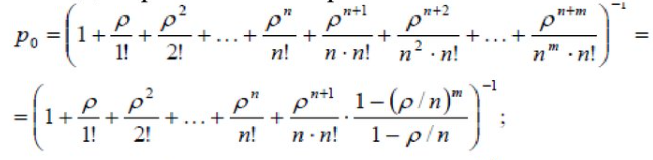

1. Определить вероятность блокировки пакета днем и ночью, если входной и
выходной поток являются пуассоновскими (4 балла).
2. Определить вероятность блокировки пакета в задаче 1, используя метод
Монте-Карло. Сравнить результаты (6 баллов).
3. Определить оптимальный размер буфера, чтобы вероятность блокировки
пакета не превышала 0.0001 (4 балла).

#### Многоканальная СМО с ограниченной очередью
Требуется найти вероятность блокировки пакета(отказа; вероятность того, что все места в очереди заняты)
Формула вероятности отказа(2):
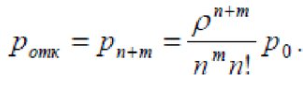

In [1]:
#1 вероятность блокировки пакета днем и ночью 
import math

# функция определения вероятности блокировки, n - кол-во концентраторов, m - размер очереди, p - интенсивность нагрузки канала
def probability(n, m, p): 
    p0 = 0 
    i = 0 
    #считаем в цикле формулу (1)
    while i <= (n + m): 
        if i <= n:
            p0 += p ** i / math.factorial(i)
        else:
            p0 += (p ** i) / (math.factorial(n) * (n ** (i - n)))
        i += 1
    p0 = p0 ** (-1)
    #считаем формулу (2)
    p_block = (p0 * (p ** (n + m))) / ((n ** m) * math.factorial(n))
    return p_block


def main():
    print("Вероятность блокировки днём: ", probability(7, 7, 84 / 25))
    print("Вероятность блокировки ночью: ", probability(7, 7, 6 / 25))


if __name__ == "__main__":
    main()

Вероятность блокировки днём:  0.0001938967547234492
Вероятность блокировки ночью:  3.986666362022827e-19


### Выводы: 
Вероятность блокировки пакета днём примерно 0.019 %, ночью - 3.99*10^-17 %, т.е близка к нулю. Система не сильно загружена, почти все заявки обрабатываются, особенно ночью. Очевидно, что интенсивность потока поступающих заявок прямо пропорциональная вероятности блокировки пакета.

In [2]:
#2 Вероятность блокировки пакета по методу Монте-Карло
import numpy as np


def model(lam):
    # Количество пакетов
    n_packets = 1000  # (16*3600*V/N = 120000)
    # Текущее время
    t = 0
    # текущий размер очереди
    queue = 0
    # Максимальный размер очереди
    m = 7
    # Интенсивность выходного потока
    mu = 25/12
    # время, когда приборы освободятся
    t_free = [0, 0, 0, 0, 0, 0, 0]
    # Количество потярянных пакетов
    n_lost = 0
    for _ in range(n_packets):
        # время поступления нового пакета
        t += np.random.exponential(scale=1 /lam)
        # проверяем есть, ли очередь
        if queue > 0:
        # ищем свободный прибор, проходясь по всем
            for j in range(7):
                while t_free[j] < t and queue > 0:
                    # обрабатываем пакеты из очереди до момента t
                    t_free[j] += np.random.exponential(scale=1 / mu)
                    # уменьшаем очередь на 1
                    queue -= 1
        # число занятых приборов
        number = 0
        # проверяем, свободны ли концентраторы
        for j in range(7):
            if t_free[j] < t:
                # Концентратор свободен, определяем время обслуживания
                t_free[j] = t + np.random.exponential(scale=1 / mu)
                break
            else:
                # увеличиваем количество занятых приборов
                number += 1
        # Концентраторы заняты
        if number == 7:
            # проверяем свободна ли очередь
            if queue < m:
                # ставим пакет в очередь
                queue += 1
            else:
                # пакет теряется
                n_lost += 1
        # print('потеряно '+str(n_lost)+' из '+str(n_packets))
    return n_lost / n_packets


def main():
    # Инициализация генеротора случайных чисел
    np.random.seed(100)
    # Количество повторов в методе Монте-Карло
    n_rep = 1000
    # Вероятность блокировки
    p_refuse = 0
    p_refuse2 = 0
    # Имитационное моделирование
    for i in range(n_rep):
        p_refuse += model(7)
        p_refuse2 += model(0.5)
    # Оценка вероятности блокировки
    p_refuse /= n_rep
    p_refuse2 /= n_rep
    print('вероятность днём = ' + str(p_refuse))
    print('вероятность ночью = ' + str(p_refuse2))


if __name__ == "__main__":
    main()


вероятность днём = 0.00021000000000000014
вероятность ночью = 0.0


### Выводы:
Вероятность днём в 1 и 2 задании совпадает до 3 знака после запятой, вероятность ночью очень мала, так же, как и в 1 задании, значит Метод Монте-Карло работает верно, также с увеличением количества повторов в методе Монте-Карло ответ становится точнее.

In [1]:
#3 Оптимальный размер буфера, чтобы вероятность блокировки пакета не превышала 0.0001
import math

# функция определения вероятности блокировки, n - кол-во концентраторов, m - размер очереди, p - интенсивность нагрузки канала
def probability(n, m, p):
    p0 = 0
    i = 0
    #считаем в цикле формулу (1)
    while i <= (n + m):
        if i <= n:
            p0 += p ** i / math.factorial(i)
        else:
            p0 += (p ** i) / (math.factorial(n) * (n ** (i - n)))
        i += 1
    p0 = p0 ** (-1)
    #считаем формулу (2)
    p_block = (p0 * (p ** (n + m))) / ((n ** m) * math.factorial(n))
    return p_block


def main():
    # перебираем в цикле все размеры, пока не найдем подходящий
    size = 0 # задаем изначальный нулевой размер буфера
    while probability(7, size, 84 / 25) > 0.0001: # проверяем больше ли вероятность чем 0.0001
        size += 1  # увеличиваем размер на 1
    print("Оптимальный размер буфера днём: ", size + 1)
    size = 0 
    while probability(7, size, 6 / 25) > 0.0001: 
        size += 1 
    print("Оптимальный размер буфера ночью: ", size + 1)



if __name__ == "__main__":
    main()


Оптимальный размер буфера днём:  9
Оптимальный размер буфера ночью:  1


### Выводы:
Оптимальный размер буфера, чтобы вероятность отказа не превышала 0.0001 днем 9, ночью - 1. То есть, ночью система может быть без очереди, и вероятность отказа будет меньше 0.0001. Очевидно, что интенсивность потока поступающих заявок прямо пропорциональная оптимальному размеру буфера для вероятности < 0.0001.